In [1]:
import numpy as np 
import pandas as pd
import random as rm
import math
import matplotlib.pyplot as plt
# shift + enter to run cells
# python3 -m pip install til at installere moduler
# control stjerne for at gøre hele linjen til en kommentar

# Simulations of particle trajectories

(10, 100)

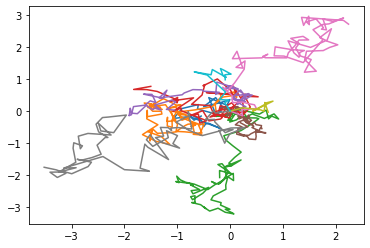

In [2]:
x0 = 0 
y0 = 0
num_tracks = 10
min_tlength = 5
max_tlength = 100
track_length = np.random.randint(min_tlength,max_tlength,size=num_tracks) 
#print(track_length)

D_track = np.random.uniform(low = 10**-3, high = 1, size=(num_tracks))
# print(D_track)
# D = np.reshape(np.repeat(D_track,track_length),(num_tracks,track_length))
dt = 1/30 # ca. 36 milli sec irl, kameratid åbent 

tracks_x = []
tracks_y = []
extend_list = []

for i in range(num_tracks):
    D = D_track[i]
    l = track_length[i]
    extend = np.repeat(0,max_tlength-1-track_length[i],axis = None)
    extend_list.append(len(extend))
    #print(extend_list)
    #print(D)
    
    two_D_t = 2*D*dt
    # pixel i kameraet = 180 nm, 220 pixels 
    step_x = np.random.normal(loc=0.0, scale=np.sqrt(two_D_t), size=l)
    #print(step_x)
    step_y = np.random.normal(loc=0.0, scale=np.sqrt(two_D_t), size=l)
    #print(step_y)
    
    def sim1 (x,y,step_x,step_y):
        y_f = np.concatenate([[y],np.cumsum(step_y)])
        x_f = np.concatenate([[x],np.cumsum(step_x)])
        return np.array([x_f,y_f])
    location = sim1(x0,y0,step_x,step_y)
    location_x = location[0]
    location_y = location[1]
    
    extend_location_x = np.insert(location_x,0,extend)
    extend_location_y = np.insert(location_y,0,extend)
    
    tracks_x.append(extend_location_x)
    tracks_y.append(extend_location_y)
    
    #plt.figure()
    plt.plot(location[0],location[1])   

data_x = np.array(tracks_x)
data_y = np.array(tracks_y)

data_x.shape

# tracks indeholder x og y for et track. Dvs hvis man kalder index 80, så får man track 80 ud af 100. 

# Machine learning with GPR

In [3]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
X = data_x
#D_opti = np.repeat(D_track[0],track_length,axis = None)
#print(D_opti)
kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e5))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
gaussian_process.fit(X,D_track)
gx = gaussian_process.predict(data_y)
gx, D_track

(array([0.40858573, 0.64625412, 0.42176155, 0.39149195, 0.18892437,
        0.63436062, 0.32556594, 0.45766552, 0.52814611, 0.55037045]),
 array([0.67566091, 0.44784716, 0.37991248, 0.68486001, 0.32278859,
        0.07931321, 0.69998078, 0.95924778, 0.62245502, 0.55031412]))

In [4]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
Y = data_y
#D_opti = np.repeat(D_track[0],track_length,axis = None)
#print(D_opti)
kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
gaussian_process.fit(Y,D_track)
gy = gaussian_process.predict(data_x)
gy, D_track

(array([0.46259409, 0.40487554, 0.19517777, 0.37379376, 0.08534621,
        0.47442098, 0.15980595, 0.18659953, 0.61934372, 0.58496304]),
 array([0.67566091, 0.44784716, 0.37991248, 0.68486001, 0.32278859,
        0.07931321, 0.69998078, 0.95924778, 0.62245502, 0.55031412]))

In [5]:
result = np.add(gx,gy)/2

mse_1 = np.mean((result-D_track)**2)
from sklearn.metrics import mean_squared_error
mse_2 = mean_squared_error(D_track,result)

print(mse_1, mse_2)

# D_track varierede fra 10**-3 til 1
# Mean squared error på 0,1 er sådan... ret stort.

# Vi benytter mean squared displacement i stedet for accuracy på vores model der har trænet på validation data, da det er regression.

0.1037987479876297 0.1037987479876297


# Fit for mean squared displacement (MSD)

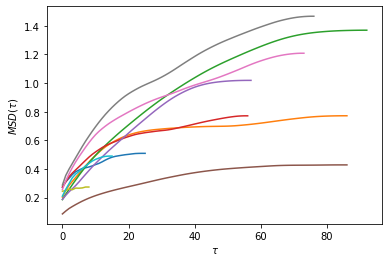

In [6]:
dix_list = []
diy_list = []
MSD_list = []
lag_list = []
a_list = []
b_list = []
r_squared_list = []

lag_list.clear()

for h in range(num_tracks): # for hvert track laver vi en liste af lags, fx lag_list = [...] x10
    lag = np.array(range(1,max_tlength-extend_list[h]))
    lag_list.append(lag)
    # print(len(lag_list[h]))

    for i in range(len(lag_list[h])): # for længden af tracket siger vi for hvert element
        for j in range(1,max_tlength-extend_list[h]-lag_list[h][i]): # j er i range af track length - nr. af lag
            diff_x = X[h][extend_list[h]+j+lag_list[h][i]] - X[h][extend_list[h]+j] # tal i track h index 0'er + 1 + 1, + 2 + 1 osv.
            diff_y = Y[h][extend_list[h]+j+lag_list[h][i]] - Y[h][extend_list[h]+j]
            dix_list.append(diff_x)
            diy_list.append(diff_y)
        MSD = np.mean(np.sqrt(np.array([dix_list])**2+np.array([diy_list])**2))
        MSD_list.append(MSD)
    # plt.figure()
    plt.plot(MSD_list)
    plt.ylabel('$MSD(τ)$')
    plt.xlabel('$ τ $')
    
    MSD_list.clear()
    dix_list.clear()
    diy_list.clear()

# antal MSD'er = track length, men da track length varierer fra track til track er antallet af MSD'er også varierende. 
# # slope/4 = Diffusion coefficient

In [ ]:
    # from scipy.optimize import curve_fit
    # def linear (x,a,b):
    #     y = a*x+b
    #     return y
    
    # x_test = np.linspace(0,10,1000)
    # popt,poc = curve_fit(linear,len(MSD_list),MSD_list, maxfev=100000)
    # plt.plot(x_test,linear(x_test,*popt), color="black")
    # # print('a:{0}  b:{1}'.format(popt[0],popt[1]))
    # a_list.append(popt[0])
    # b_list.append(popt[1])
    
    # def yopt (x,a,b):
    #     y = a*x+b
    #     return y
    
    # residuals = np.array(MSD_list[h])-np.array(yopt(MSD_list[h],a_list[h],b_list[h]))
    # ss_res = np.sum(residuals**2)
    # ss_tot = np.sum((MSD_list-np.mean(MSD_list))**2)
    # r_squared = 1 - (ss_res / ss_tot)
    # print(r_squared)
    
    # r_squared_list.append(r_squared)